In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

%matplotlib inline

In [2]:
PATH = Path('.')

In [3]:
device = "cuda:6" if torch.cuda.is_available() else "cpu"

In [4]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [5]:
train_ds = datasets.MNIST(PATH / "MNIST", train=True, transform=tfms, download=True)
test_ds = datasets.MNIST(PATH / "MNIST", train=False, transform=tfms, download=True)

In [6]:
train_dl = data.DataLoader(train_ds, batch_size=60)
test_dl = data.DataLoader(test_ds, batch_size=60, shuffle=False)

In [7]:
def plot_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()
    

In [8]:
class ConvolutionalAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # 16 x 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # 16 x 14 x 14
            nn.Conv2d(16, 32, 3, padding=1),  # 32 x 14 x 14
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),  # 32 x 7 x 7
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2), # 16 x 15 x 15
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, padding=2, stride=2, output_padding=1), # 1 x 28 x 28
            nn.Tanh()
        )
        self.optim = optim.Adam(self.parameters(), lr=1e-4)
        self._loss = None
        
    def forward(self, x):
        x =self.encoder(x)
        x = self.decoder(x)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.mse_loss(output, target, **kwargs)
        return self._loss

In [9]:
ae = ConvolutionalAE().to(device)

In [10]:
%%time
for epoch in range(1, 101):
    train_loss = 0.
    train_size = len(train_dl)
    for data, _ in train_dl:
        ae.optim.zero_grad()
        data = data.to(device)
        output = ae(data)
        loss = ae.loss(output, data)
        loss.backward()
        ae.optim.step()
        train_loss += ae._loss.item()
    train_loss /= train_size
    print(f"Epoch {epoch}: {train_loss}")

Epoch 1: 0.28604577150195837
Epoch 2: 0.06553974352404475
Epoch 3: 0.036878654273226855
Epoch 4: 0.026491291131824257
Epoch 5: 0.02096819610428065
Epoch 6: 0.017646276536397637
Epoch 7: 0.015546269122511149
Epoch 8: 0.014074362021870911
Epoch 9: 0.01298215792234987
Epoch 10: 0.012148573492653667
Epoch 11: 0.01148614378273487
Epoch 12: 0.010926251147873699
Epoch 13: 0.01043635700410232
Epoch 14: 0.010020558321848512
Epoch 15: 0.009665249669458717
Epoch 16: 0.009352454998064787
Epoch 17: 0.009073782629333437
Epoch 18: 0.008826919962652028
Epoch 19: 0.008606478370260448
Epoch 20: 0.008407921285368502
Epoch 21: 0.00822818574961275
Epoch 22: 0.008065964090172201
Epoch 23: 0.007918895612470805
Epoch 24: 0.007784277710132301
Epoch 25: 0.007659814963117242
Epoch 26: 0.007543816474732012
Epoch 27: 0.007435259821824729
Epoch 28: 0.00733344892738387
Epoch 29: 0.007237723732367158
Epoch 30: 0.0071478400491178035
Epoch 31: 0.007063577932771296
Epoch 32: 0.006984417501371354
Epoch 33: 0.006909876023

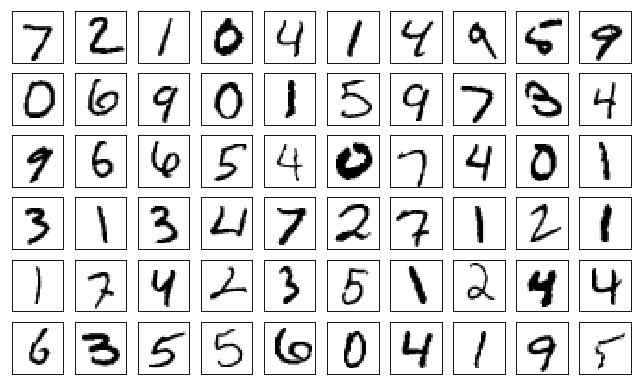

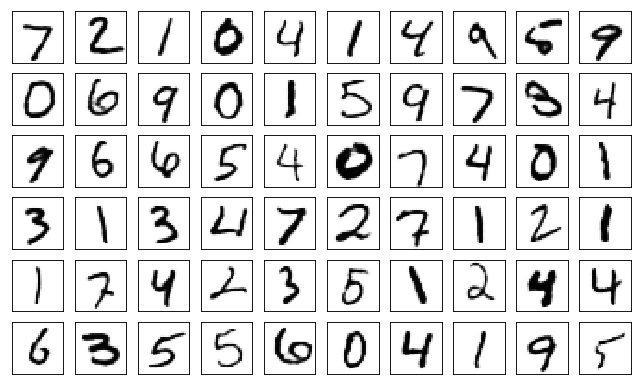

In [11]:
ae.eval()
img, _ = next(iter(test_dl))
output = ae(img.to(device))
plot_mnist(img, (6,10))
plot_mnist(output.data.cpu().numpy(), (6,10))

In [12]:
torch.save(ae.state_dict(), PATH / 'my_conv_ae.model')

## Fit image to specific actiovation pattern

In [13]:
class FitImageToActivationModel(nn.Module):
    def __init__(self, image, traget_activation):
        super().__init__()
        self.image = nn.Parameter(image)
        self.traget_activation = traget_activation
        self.optim = optim.Adam(self.parameters(), lr=1e-2)
        self._loss = None
        
    def forward(self, encoder):
        out = encoder(self.image)
        return out
    
    def loss(self, output):
        self._loss = F.mse_loss(output, self.traget_activation)
        return self._loss

### Target activation pattern

In [14]:
target_activation = torch.ones(7,7)
target_activation = target_activation[None, None, :, :]
target_activation = target_activation.expand(1,32,7,7)
target_activation = target_activation.to(device)
target_activation

tensor([[[[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          ...,
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.]],

         [[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          ...,
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.]],

         [[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          ...,
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.]],

         ...,

         [[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  

### Plot original image

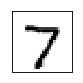

In [15]:
dl = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False) 
img, c = next(iter(dl))
plot_mnist(img, (1,1))

### Original activation pattern

In [16]:
ae.encoder(img.to(device))

tensor([[[[ 0.4562,  0.4052,  0.4052,  ...,  0.4052,  0.4052,  0.4698],
          [ 0.3143,  0.9120,  0.9324,  ...,  0.8117,  0.6278,  0.2408],
          [ 0.4257,  0.9960,  0.9999,  ...,  0.9999,  0.9997,  0.3212],
          ...,
          [ 0.2192,  0.1586,  0.1576,  ...,  0.9994,  0.1839,  0.2460],
          [ 0.2192,  0.1586,  0.9829,  ...,  0.9420,  0.1586,  0.2460],
          [ 0.2030,  0.2438,  0.9997,  ...,  0.1344,  0.1370,  0.2585]],

         [[ 0.0389, -0.1107, -0.1107,  ..., -0.1107, -0.1107, -0.1052],
          [ 0.0342, -0.0679, -0.1576,  ..., -0.1036, -0.1310, -0.0810],
          [ 0.0342, -0.2234, -0.2971,  ..., -0.7216, -0.3614, -0.0702],
          ...,
          [ 0.0342, -0.1039, -0.0846,  ..., -0.2828, -0.1044, -0.0962],
          [ 0.0342, -0.0998, -0.0950,  ..., -0.1262, -0.1039, -0.0962],
          [ 0.0622, -0.0444, -0.2503,  ..., -0.0532, -0.0532, -0.0534]],

         [[ 0.3128,  0.1837,  0.1837,  ...,  0.1837,  0.1837,  0.1394],
          [ 0.0108, -0.0400, -

### optimize image

In [17]:
ae.eval()

f2a = FitImageToActivationModel(img, target_activation).to(device)
f2a.train()

for i in range(1, 100_001):
    f2a.optim.zero_grad()
    out = f2a(ae.encoder)
    loss = f2a.loss(out)
    loss.backward()
    f2a.optim.step()
    if i % 1000 == 0:
        print(loss.item())

0.20428074896335602
0.14995627105236053
0.12299828976392746
0.10096785426139832
0.08408604562282562
0.07102291285991669
0.06216958537697792
0.05475533381104469
0.04971267655491829
0.04631771892309189
0.04366467893123627
0.042016543447971344
0.04092143476009369
0.040102120488882065
0.039534054696559906
0.03913508355617523
0.038863200694322586
0.03868129849433899
0.03855665773153305
0.038468506187200546
0.03840753436088562
0.038365259766578674
0.03833606839179993
0.03831520304083824
0.03830093890428543
0.03829079493880272
0.03828388825058937
0.038279034197330475
0.03827560320496559
0.0382731556892395
0.038271378725767136
0.03827011212706566
0.03826918080449104
0.038268495351076126
0.038267988711595535
0.0382675975561142
0.03826729208230972
0.03826704993844032
0.038266848772764206
0.03826666623353958
0.03826652839779854
0.038266416639089584
0.03826632350683212
0.03826623782515526
0.038266174495220184
0.03826611116528511
0.03826605901122093
0.03826601803302765
0.03826597332954407
0.0382659

### Extract target image

In [18]:
target_img = f2a.image.detach()

### Optimized activation pattern

In [19]:
ae.encoder(target_img)

tensor([[[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],

         [[ 0.9995,  0.9994,  0.9994,  ...,  0.9988,  0.9998,  0.9997],
          [ 0.9994,  1.0000,  0.9993,  ...,  0.9994,  0.9996,  0.9997],
          [ 0.9976,  0.9991,  0.9993,  ...,  0.9997,  1.0000,  1.0000],
          ...,
          [ 0.9989,  0.9991,  0.9991,  ...,  0.9993,  0.9994,  0.9996],
          [ 0.9999,  0.9995,  0.9989,  ...,  0.9994,  0.9992,  0.9994],
          [ 0.9990,  0.9992,  1.0000,  ...,  0.9992,  0.9995,  0.9996]],

         [[ 1.0000,  1.0000,  0.9996,  ...,  1.0000,  0.9993,  1.0000],
          [ 0.9995,  1.0000,  

### Optimized image

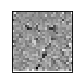

In [20]:
plot_mnist(target_img, (1,1))

# Convolutional classifier

In [21]:
class ConvolutionalClassifier(nn.Module):
    def __init__(self, lr = 1e-4):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  
            nn.Conv2d(16, 32, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)  
        )
        self.fc = nn.Sequential(
            nn.Linear(32*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr)
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32*7*7)
        x = self.fc(x)
        out = F.log_softmax(x, dim=1)
        return out
    
    def loss(self, output, target):
        self._loss = F.nll_loss(output, target)
        return self._loss

In [22]:
clf = ConvolutionalClassifier().to(device)

In [23]:
%%time
for epoch in range(1, 21):
    train_loss = 0.
    train_size = len(train_dl)
    clf.train()
    for data, target in train_dl:
        clf.optim.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = clf(data)
        loss = clf.loss(output, target)
        loss.backward()
        clf.optim.step()
        train_loss += clf._loss.item()
    train_loss /= train_size
    print(f"Epoch {epoch}: {train_loss}")
    
    clf.eval()
    batch_size = 60
    test_loss = 0.
    test_size = len(test_dl) 
    correct = 0
    for data, target in test_dl:
        data = data.to(device)
        target = target.to(device)
        output = clf(data)
        _, pred = torch.max(output.data, 1)
        correct += (pred==target).sum().item()
        test_loss += clf.loss(output, target).item()
    test_loss /= test_size
    print(f"Test loss: {test_loss}, Accuracy: {correct}/{test_size * batch_size} {correct/(test_size * batch_size)}%")
        

Epoch 1: 0.6570060520879925
Test loss: 0.25860551545050686, Accuracy: 9241/10020 0.9222554890219561%
Epoch 2: 0.21326184768974782
Test loss: 0.1562654691982546, Accuracy: 9532/10020 0.9512974051896208%
Epoch 3: 0.14090551417693495
Test loss: 0.10909693975637327, Accuracy: 9671/10020 0.9651696606786427%
Epoch 4: 0.10424067667359486
Test loss: 0.08601883599885968, Accuracy: 9747/10020 0.9727544910179641%
Epoch 5: 0.08361022334592418
Test loss: 0.07214338622093591, Accuracy: 9792/10020 0.9772455089820359%
Epoch 6: 0.07041516745137051
Test loss: 0.0625687391773594, Accuracy: 9812/10020 0.9792415169660679%
Epoch 7: 0.060960288818925616
Test loss: 0.05523547318308826, Accuracy: 9825/10020 0.9805389221556886%
Epoch 8: 0.0537978176663164
Test loss: 0.050024408728935515, Accuracy: 9836/10020 0.9816367265469061%
Epoch 9: 0.04811940729408525
Test loss: 0.046482172158015554, Accuracy: 9840/10020 0.9820359281437125%
Epoch 10: 0.04349923615262378
Test loss: 0.043650853104121194, Accuracy: 9850/10020

In [24]:
torch.save(clf.state_dict(), PATH / 'my_conv_clf.model')

## Fit images from different classes to class 8

In [25]:
class FitImageToClassModel(nn.Module):
    def __init__(self, image, traget_class):
        super().__init__()
        self.image = nn.Parameter(image)
        self.target_class = torch.ones(image.shape[0], dtype=torch.long)*8
        self.target_class = self.target_class.to(device)
        self.optim = optim.Adam(self.parameters(), lr=1e-3)
        self._loss = None
        
    def forward(self, classifier):
        out = classifier(self.image)
        return out
    
    def loss(self, output):
        self._loss = F.nll_loss(output, self.target_class)
        return self._loss

### Print original images

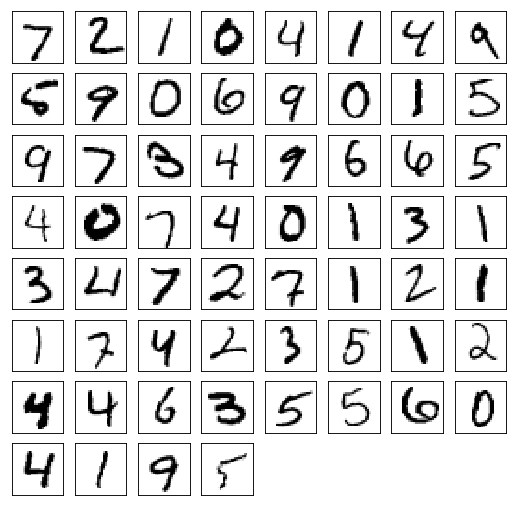

tensor([ 7,  2,  1,  0,  4,  1,  4,  9,  5,  9,  0,  6,  9,  0,
         1,  5,  9,  7,  3,  4,  9,  6,  6,  5,  4,  0,  7,  4,
         0,  1,  3,  1,  3,  4,  7,  2,  7,  1,  2,  1,  1,  7,
         4,  2,  3,  5,  1,  2,  4,  4,  6,  3,  5,  5,  6,  0,
         4,  1,  9,  5]) torch.Size([60])


In [26]:
imgs, c = next(iter(test_dl))
plot_mnist(imgs, (8,8))
print(c, c.shape)

### Optimize images

In [27]:
clf.eval()

f2c = FitImageToClassModel(imgs, 8).to(device)
f2c.train()

for i in range(1, 20_001):
    f2c.optim.zero_grad()
    out = f2c(clf)
    loss = f2c.loss(out)
    loss.backward()
    f2c.optim.step()
    if i % 1000 == 0:
        print(loss.item())

0.006693537812680006
0.0018019437557086349
0.0007801453466527164
0.0003983418282587081
0.00021870135969948024
0.00012531279935501516
7.351239764830098e-05
4.364649430499412e-05
2.6178360712947324e-05
1.5799205357325263e-05
9.56853273237357e-06
5.801518909720471e-06
3.496805902614142e-06
2.1457672119140625e-06
1.1285145546935382e-06
8.424123052463983e-07
2.066294371161348e-07
3.1789145538141383e-08
0.0
0.0


### Extract optimized images

In [28]:
target_imgs = f2c.image.detach()

### Classify and plot optimized images

In [29]:
torch.argmax(clf(target_imgs), dim=1)

tensor([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8], device='cuda:6')

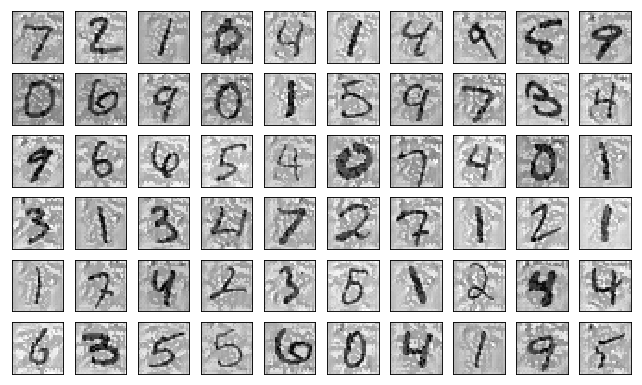

In [30]:
plot_mnist(target_imgs, (6,10))